In [12]:
import kagglehub
import warnings
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import holidays
from statsmodels.tsa.stattools import adfuller

In [2]:
import os
from dotenv import load_dotenv
import pandas as pd

load_dotenv("../.env")

dir_ds = os.getenv("HEPC")

df = pd.read_csv(
    dir_ds,
    sep=';',
    na_values=['?'],
    low_memory=False
)

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

In [5]:
df = df.set_index('date_time')

In [6]:
df = df.drop(columns=['Date', 'Time'])

In [7]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [9]:
# EDA
# Выбросы
# Нейронки не трогать
# стационарность

In [10]:
df_fill = df.ffill()

In [11]:
df_fill.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [12]:
df.count()

Global_active_power      2049280
Global_reactive_power    2049280
Voltage                  2049280
Global_intensity         2049280
Sub_metering_1           2049280
Sub_metering_2           2049280
Sub_metering_3           2049280
dtype: int64

In [15]:
df_f_r = df_fill.resample('1h').mean()

In [16]:
series = df_f_r['Global_active_power']
result = adfuller(series)

result[1]

1.4126108207425066e-26

In [14]:
df_f_r = df_f_r.reset_index()

In [15]:
df_f_r['hour'] = df_f_r['date_time'].dt.hour

In [16]:
df_f_r['dow'] = df_f_r['date_time'].dt.dayofweek

In [17]:
df_f_r['month'] = df_f_r['date_time'].dt.month

In [18]:
df_f_r = df_f_r.set_index('date_time')

In [19]:
df_f_r.sort_index(inplace=True)

In [20]:
df_f_r['lag_1h_Global_active_power'] = df_f_r['Global_active_power'].shift(freq='1h')
df_f_r['lag_2h_Global_active_power'] = df_f_r['Global_active_power'].shift(freq='2h')
df_f_r['lag_3h_Global_active_power'] = df_f_r['Global_active_power'].shift(freq='3h')

In [21]:
df_f_r['lag_24h_Global_active_power'] = df_f_r['Global_active_power'].shift(freq='1d')

In [22]:
fr_holidays = holidays.France()
df_f_r['is_holiday'] = df_f_r.index.map(lambda x: x in fr_holidays).astype(int)

In [23]:
df_f_r.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'hour', 'dow', 'month', 'lag_1h_Global_active_power',
       'lag_2h_Global_active_power', 'lag_3h_Global_active_power',
       'lag_24h_Global_active_power', 'is_holiday'],
      dtype='object')

In [24]:
df_f_r['is_weekend'] = (df_f_r['dow'] >= 5).astype(int)

In [25]:
df_f_r['lag_168h_Global_active_power'] = df_f_r['Global_active_power'].shift(freq='168h')

In [26]:
df_f_r['roll_mean_24_Global_active_power'] = df_f_r['Global_active_power'].shift(freq='1h').rolling(window=24).mean()

In [27]:
df_f_r['roll_std_24_Global_active_power'] = df_f_r['Global_active_power'].shift(freq='1h').rolling(window=24).std()

In [28]:
df_f_r.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'hour', 'dow', 'month', 'lag_1h_Global_active_power',
       'lag_2h_Global_active_power', 'lag_3h_Global_active_power',
       'lag_24h_Global_active_power', 'is_holiday', 'is_weekend',
       'lag_168h_Global_active_power', 'roll_mean_24_Global_active_power',
       'roll_std_24_Global_active_power'],
      dtype='object')

In [29]:
df_f_r['Other'] = df_f_r['Global_active_power'] * 1000 / 60 - (df_f_r['Sub_metering_1'] + df_f_r['Sub_metering_2'] + df_f_r['Sub_metering_3'])

In [30]:
df_f_r['lag_1_Other'] = df_f_r['Other'].shift(freq='1h')

In [31]:
df_f_r['lag_1h_Voltage'] = df_f_r['Voltage'].shift(freq='1h')
df_f_r['lag_1h_Global_intensity'] = df_f_r['Global_intensity'].shift(freq='1h')
df_f_r['lag_1h_Sub_metering_1'] = df_f_r['Sub_metering_1'].shift(freq='1h')
df_f_r['lag_1h_Sub_metering_2'] = df_f_r['Sub_metering_2'].shift(freq='1h')
df_f_r['lag_1h_Sub_metering_3'] = df_f_r['Sub_metering_3'].shift(freq='1h')
df_f_r['lag_1h_Global_reactive_power'] = df_f_r['Global_reactive_power'].shift(freq='1h')

In [32]:
df_f_r['hour_sin'] = np.sin(2 * np.pi * df_f_r['hour'] / 24)
df_f_r['hour_cos'] = np.cos(2 * np.pi * df_f_r['hour'] / 24)

In [33]:
df_f_r.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'hour', 'dow', 'month', 'lag_1h_Global_active_power',
       'lag_2h_Global_active_power', 'lag_3h_Global_active_power',
       'lag_24h_Global_active_power', 'is_holiday', 'is_weekend',
       'lag_168h_Global_active_power', 'roll_mean_24_Global_active_power',
       'roll_std_24_Global_active_power', 'Other', 'lag_1_Other',
       'lag_1h_Voltage', 'lag_1h_Global_intensity', 'lag_1h_Sub_metering_1',
       'lag_1h_Sub_metering_2', 'lag_1h_Sub_metering_3',
       'lag_1h_Global_reactive_power', 'hour_sin', 'hour_cos'],
      dtype='object')

In [34]:
df_f_r = df_f_r.dropna()

In [35]:
df_f_r.isnull().sum()

Global_active_power                 0
Global_reactive_power               0
Voltage                             0
Global_intensity                    0
Sub_metering_1                      0
Sub_metering_2                      0
Sub_metering_3                      0
hour                                0
dow                                 0
month                               0
lag_1h_Global_active_power          0
lag_2h_Global_active_power          0
lag_3h_Global_active_power          0
lag_24h_Global_active_power         0
is_holiday                          0
is_weekend                          0
lag_168h_Global_active_power        0
roll_mean_24_Global_active_power    0
roll_std_24_Global_active_power     0
Other                               0
lag_1_Other                         0
lag_1h_Voltage                      0
lag_1h_Global_intensity             0
lag_1h_Sub_metering_1               0
lag_1h_Sub_metering_2               0
lag_1h_Sub_metering_3               0
lag_1h_Globa

In [36]:
total_data = df_f_r.drop(columns=['Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Other'])

In [37]:
total_data.columns

Index(['Global_active_power', 'hour', 'dow', 'month',
       'lag_1h_Global_active_power', 'lag_2h_Global_active_power',
       'lag_3h_Global_active_power', 'lag_24h_Global_active_power',
       'is_holiday', 'is_weekend', 'lag_168h_Global_active_power',
       'roll_mean_24_Global_active_power', 'roll_std_24_Global_active_power',
       'lag_1_Other', 'lag_1h_Voltage', 'lag_1h_Global_intensity',
       'lag_1h_Sub_metering_1', 'lag_1h_Sub_metering_2',
       'lag_1h_Sub_metering_3', 'lag_1h_Global_reactive_power', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [38]:
split_date_val = '2010-01-01'
split_date_test = '2010-10-01'

In [39]:
train = total_data.loc[total_data.index < split_date_val]
val = total_data.loc[(total_data.index >= split_date_val) & (total_data.index < split_date_test)]
test = total_data.loc[total_data.index >= split_date_test]

In [40]:
X_train, y_train = train.drop(columns=['Global_active_power']), train['Global_active_power']
X_val, y_val = val.drop(columns=['Global_active_power']), val['Global_active_power']
X_test, y_test = test.drop(columns=['Global_active_power']), test['Global_active_power']

In [41]:
print(X_train.shape, '\n', X_val.shape, '\n', X_test.shape)

(26503, 21) 
 (6552, 21) 
 (1366, 21)


In [42]:
cat_features = ['hour', 'dow', 'month', 'is_weekend']

In [43]:
lr = 1e-3

In [44]:
model = lgb.LGBMRegressor(
    objective='mae', # если regression (mse) будет слишком потужно, попробовать mae, но mse = меньше выбросов. Ну я выиграл 2 сотых
    n_estimators=10000,
    learning_rate=lr,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

In [45]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='mae',
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ],
    categorical_feature=cat_features
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3660
[LightGBM] [Info] Number of data points in the train set: 26503, number of used features: 21
[LightGBM] [Info] Start training from score 0.781433
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.672307	valid_1's l1: 0.566431
[200]	training's l1: 0.631489	valid_1's l1: 0.530667
[300]	training's l1: 0.595292	valid_1's l1: 0.499434
[400]	training's l1: 0.563303	valid_1's l1: 0.472435
[500]	training's l1: 0.534927	valid_1's l1: 0.449107
[600]	training's l1: 0.509633	valid_1's l1: 0.428597
[700]	training's l1: 0.487586	valid_1's l1: 0.410734
[800]	training's l1: 0.468508	valid_1's l1: 0.395119
[900]	training's l1: 0.451713	valid_1's l1: 0.381608
[1000]	training's l1: 0.437173	valid_1's l1: 0.370155
[

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.001
,n_estimators,10000
,subsample_for_bin,200000
,objective,'mae'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [46]:
preds = model.predict(X_test)
score = mean_absolute_error(y_test, preds)
print(f"MAE Test: {score:.4f} kW")

MAE Test: 0.3401 kW


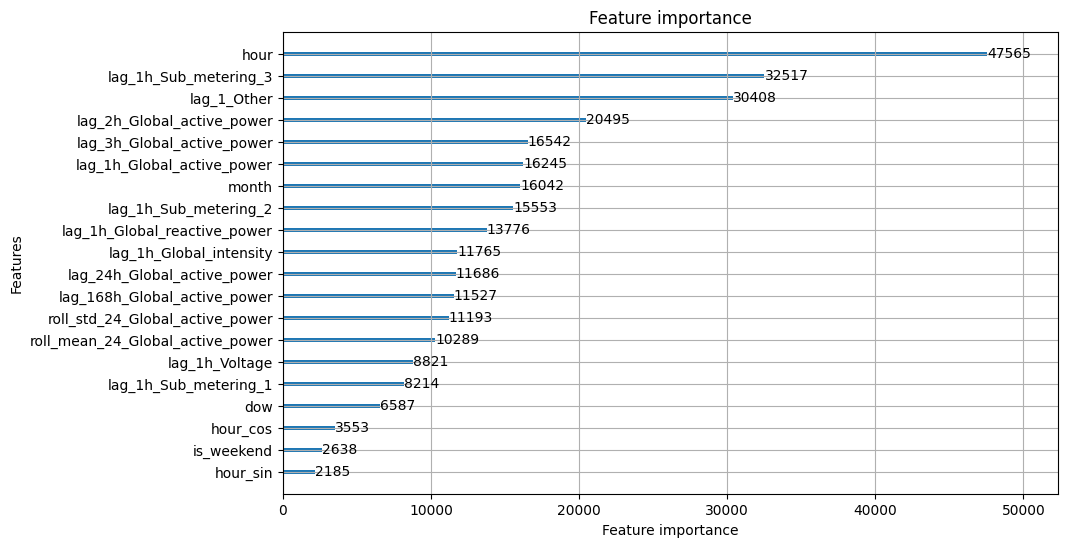

In [47]:
lgb.plot_importance(model, max_num_features=20, figsize=(10, 6))
plt.show()

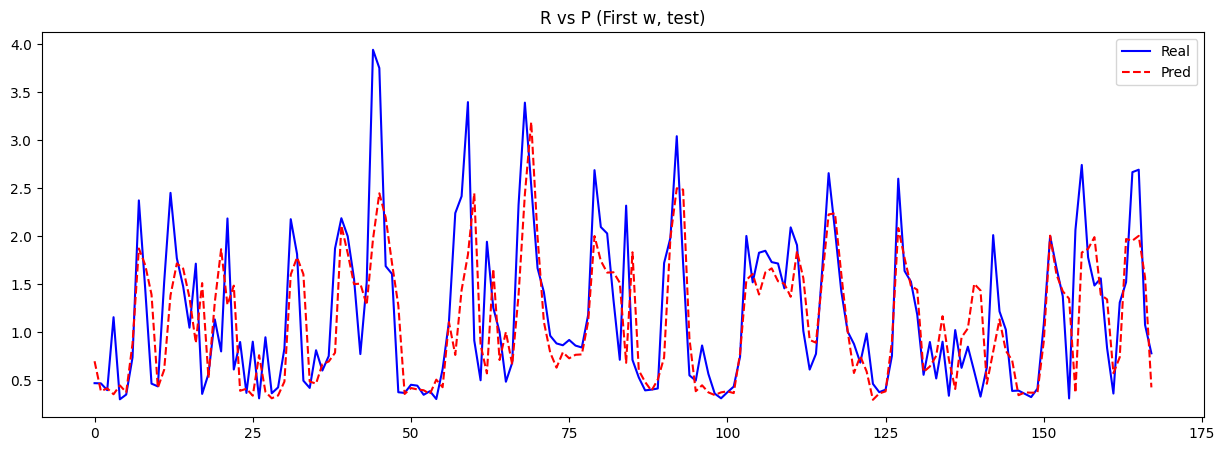

In [48]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.iloc[:168].values, label='Real', color='blue')
plt.plot(preds[:168], label='Pred', color='red', linestyle='--')
plt.legend()
plt.title("R vs P (First w, test)")
plt.show()

In [49]:
# 340 ватт ошибка
# Ну, я не знаю норм это результат или нет, но идей у меня больше нет